In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

In [2]:
df = pd.read_csv('CATS_23_24.csv')

In [3]:
def normalize_columns(cols):
    """Normaliza nomes das colunas para facilitar acesso."""
    clean = []
    for c in cols:
        s = str(c).strip().lower()
        s = re.sub(r"[^\w]+", "_", s)  # substitui espaços/pontos/virgulas por underscore
        s = re.sub(r"_+", "_", s).strip("_")
        clean.append(s)
    return clean

def find_col(df, keywords):
    """
    Acha primeira coluna do df que contenha qualquer substring em keywords.
    keywords pode ser lista de strings.
    Retorna None se não encontrado.
    """
    cols = df.columns
    for kw in keywords:
        for c in cols:
            if kw in c:
                return c
    return None

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)


In [4]:
df.columns = normalize_columns(df.columns)

In [5]:
# Palavras-chave candidatas baseadas no seu CSV
col_agente = find_col(df, ["agente", "causador"])
col_municipio = find_col(df, ["municipio", "munic", "municipio_empregador", "municipio_empreg"])
col_cbo = find_col(df, ["cbo"])
col_cnae = find_col(df, ["cnae"])
col_data_acidente = find_col(df, ["data_acidente", "data", "acidente"])
col_indica_obito = find_col(df, ["obito", "óbito", "indica_obito", "indica_obito_acidente"])
col_data_nasc = find_col(df, ["nascimento", "data_nasc", "data_de_nascimento", "data_nascimento"])
col_sexo = find_col(df, ["sexo"])
col_cid10 = find_col(df, ["cid", "cid10"])

print("\nColunas detectadas:")
print(" Agente:", col_agente)
print(" Municipio:", col_municipio)
print(" CBO:", col_cbo)
print(" CNAE:", col_cnae)
print(" Data_Acidente:", col_data_acidente)
print(" Indica_Óbito:", col_indica_obito)
print(" Data_Nascimento:", col_data_nasc)
print(" Sexo:", col_sexo)
print(" CID10:", col_cid10)


Colunas detectadas:
 Agente: agente_causador_acidente
 Municipio: municipio_empregador
 CBO: cbo
 CNAE: cnae_empregador
 Data_Acidente: data_acidente
 Indica_Óbito: indica_óbito_acidente
 Data_Nascimento: data_nascimento
 Sexo: sexo
 CID10: agente_causador_acidente


In [6]:
# Datas
def to_datetime_safe(s):
    try:
        return pd.to_datetime(s, dayfirst=False, errors="coerce")
    except:
        return pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")

if col_data_acidente:
    df["data_acidente_parsed"] = to_datetime_safe(df[col_data_acidente])
else:
    df["data_acidente_parsed"] = pd.NaT

if col_data_nasc:
    df["data_nascimento_parsed"] = to_datetime_safe(df[col_data_nasc])
else:
    df["data_nascimento_parsed"] = pd.NaT

# Idade aproximada em anos (quando data de nascimento válida)
ref_date = pd.Timestamp.now()
df["idade_anos"] = np.floor((ref_date - df["data_nascimento_parsed"]).dt.days / 365.25)
df.loc[df["idade_anos"] < 0, "idade_anos"] = np.nan

# Normaliza indicador óbito para string lower
if col_indica_obito:
    df["obito_flag"] = df[col_indica_obito].astype(str).str.lower().str.contains("sim|s|1|true", na=False)
else:
    df["obito_flag"] = False

# Substitui strings 'desconhecido' ou 'nan' por NaN
df = df.replace({"desconhecido": np.nan, "nan": np.nan, "none": np.nan})

/tmp/ipython-input-245975319.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"desconhecido": np.nan, "nan": np.nan, "none": np.nan})


In [7]:
print("\nShape do dataset:", df.shape)
print("\nColunas e tipos:")
print(df.dtypes)

print("\nContagem de valores nulos por coluna (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

ensure_dir("figs")
plt.figure(figsize=(10,4))
msno.matrix(df.sample(n=min(2000, len(df))), fontsize=8)
plt.title("Mapa de valores faltantes (amostra)")
plt.savefig("figs/missing_matrix.png", bbox_inches="tight")
plt.close()

plt.figure(figsize=(8,6))
msno.bar(df, fontsize=8)
plt.title("Contagem de valores não-nulos por coluna")
plt.savefig("figs/missing_bar.png", bbox_inches="tight")
plt.close()


Shape do dataset: (86571, 17)

Colunas e tipos:
unnamed_0                            int64
agente_causador_acidente            object
data_acidente                       object
cbo                                 object
cid10                               object
cnae_empregador                     object
indica_óbito_acidente               object
municipio_empregador                object
sexo                                object
uf_munic_acidente                   object
data_nascimento                     object
cbo_detalhado                      float64
data_afastamento                   float64
data_acidente_parsed        datetime64[ns]
data_nascimento_parsed      datetime64[ns]
idade_anos                         float64
obito_flag                            bool
dtype: object

Contagem de valores nulos por coluna (top 20):
cbo_detalhado               86571
data_afastamento            86571
idade_anos                    637
data_nascimento_parsed        637
data_nascimento       

<Figure size 1000x400 with 0 Axes>

In [8]:

# Números gerais
total_acidentes = len(df)
n_mun = df[col_municipio].nunique() if col_municipio else None
n_cbos = df[col_cbo].nunique() if col_cbo else None
n_cnaes = df[col_cnae].nunique() if col_cnae else None
n_obitos = df["obito_flag"].sum()

print(f"\nTotal de registros: {total_acidentes}")
print(f"Registros com óbito flag = True: {n_obitos}")
print(f"Nº municípios distintos (col detectada): {n_mun}")
print(f"Nº CBO distintos (col detectada): {n_cbos}")
print(f"Nº CNAE distintos (col detectada): {n_cnaes}")

desc_num = df[["idade_anos"]].describe()
print("\nDescrição numérica (idade):\n", desc_num)



Total de registros: 86571
Registros com óbito flag = True: 245
Nº municípios distintos (col detectada): 1812
Nº CBO distintos (col detectada): 1521
Nº CNAE distintos (col detectada): 597

Descrição numérica (idade):
          idade_anos
count  85934.000000
mean      38.324109
std       11.526543
min       15.000000
25%       29.000000
50%       37.000000
75%       46.000000
max      105.000000


In [9]:

def topn_counts(df, col, n=10):
    if col is None:
        return pd.Series([], dtype=int)
    s = df[col].fillna("<<NA>>").value_counts().head(n)
    return s

def plot_topn(series, title, xlabel=None, filename=None, rotate=45):
    if series.empty:
        print(f"Aviso: serie vazia para {title}")
        return
    plt.figure(figsize=(10,6))
    sns.barplot(x=series.values, y=series.index, orient="h")
    plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches="tight")
        print("Salvo:", filename)
    plt.show()
    plt.close()


Salvo: figs/top10/top10_agentes.png


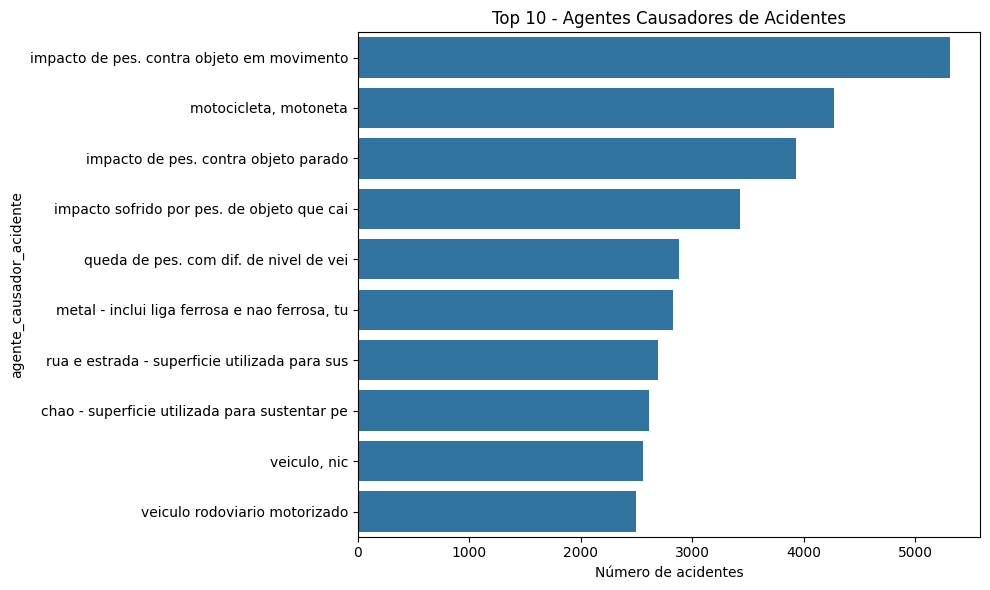

Salvo: figs/top10/top10_municipios.png


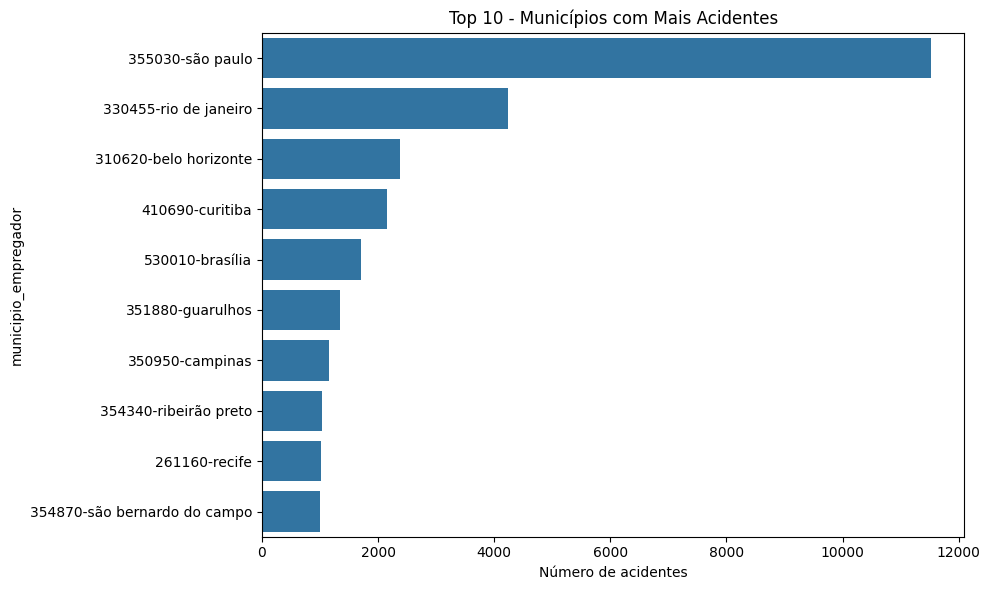

Salvo: figs/top10/top10_agentes_fatais.png


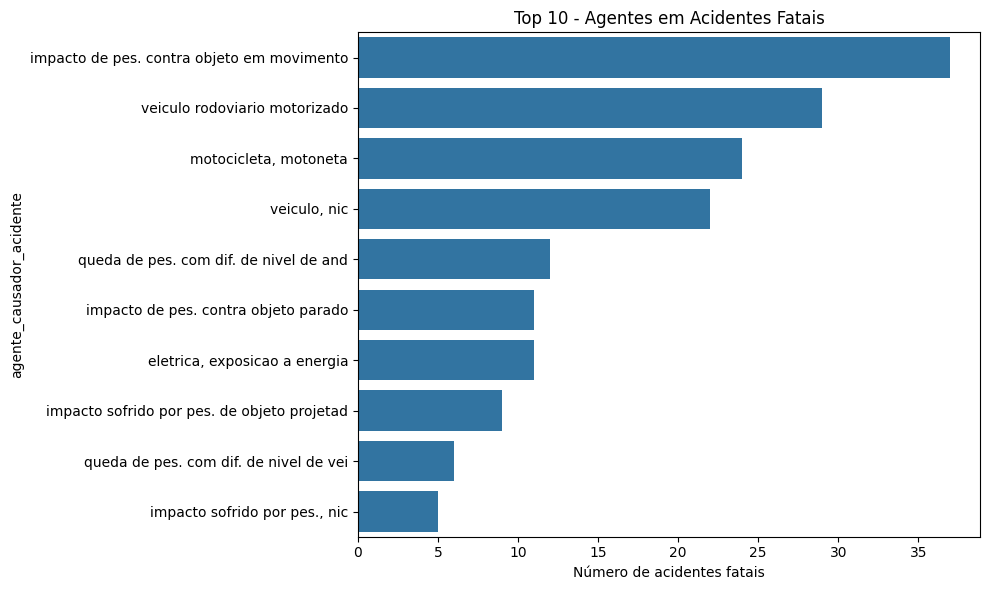

Salvo: figs/top10/top10_cbos.png


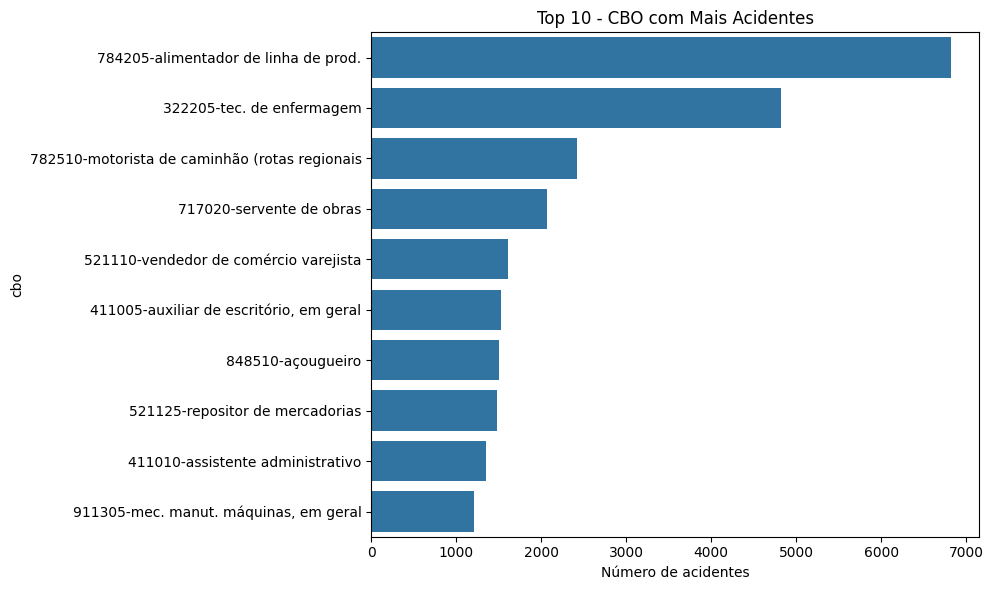

Salvo: figs/top10/top10_cnaes.png


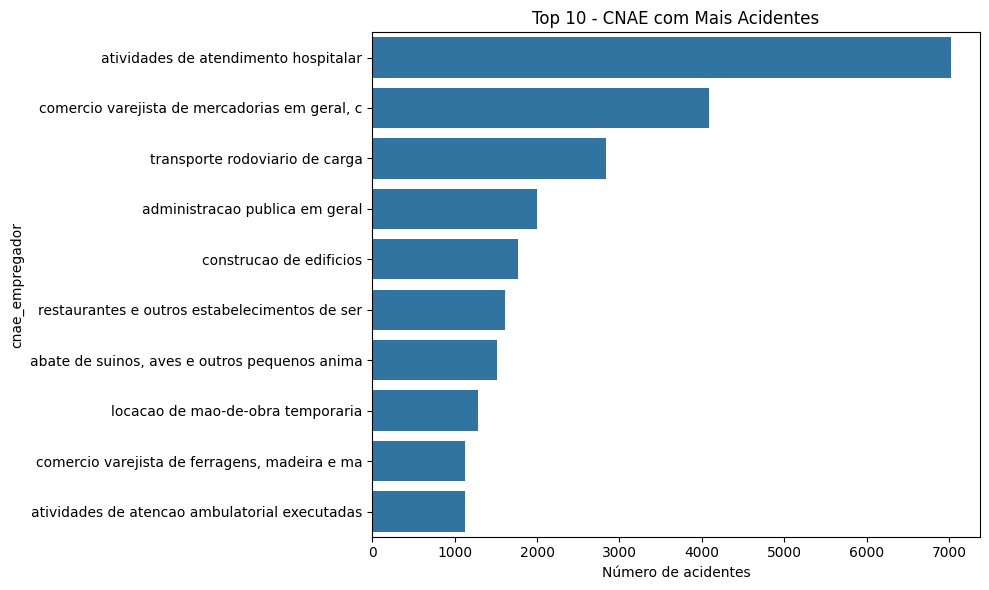

In [10]:

ensure_dir("figs/top10")

top_agentes = topn_counts(df, col_agente, 10)
plot_topn(top_agentes, "Top 10 - Agentes Causadores de Acidentes", "Número de acidentes", "figs/top10/top10_agentes.png")

top_municipios = topn_counts(df, col_municipio, 10)
plot_topn(top_municipios, "Top 10 - Municípios com Mais Acidentes", "Número de acidentes", "figs/top10/top10_municipios.png")

# Agentes em acidentes fatais
top_agentes_fatais = topn_counts(df[df["obito_flag"]==True], col_agente, 10)
plot_topn(top_agentes_fatais, "Top 10 - Agentes em Acidentes Fatais", "Número de acidentes fatais", "figs/top10/top10_agentes_fatais.png")

top_cbos = topn_counts(df, col_cbo, 10)
plot_topn(top_cbos, "Top 10 - CBO com Mais Acidentes", "Número de acidentes", "figs/top10/top10_cbos.png")

top_cnaes = topn_counts(df, col_cnae, 10)
plot_topn(top_cnaes, "Top 10 - CNAE com Mais Acidentes", "Número de acidentes", "figs/top10/top10_cnaes.png")

/tmp/ipython-input-2207608637.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index("data_acidente_parsed").resample("M").size()


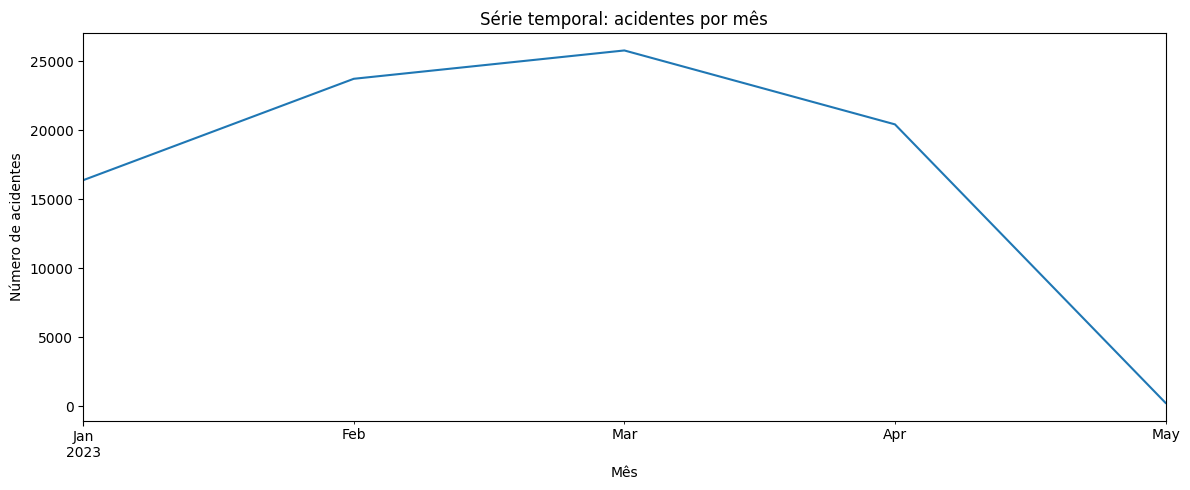

In [11]:

if "data_acidente_parsed" in df.columns and not df["data_acidente_parsed"].isna().all():
    ts = df.set_index("data_acidente_parsed").resample("M").size()
    plt.figure(figsize=(12,5))
    ts.plot()
    plt.title("Série temporal: acidentes por mês")
    plt.ylabel("Número de acidentes")
    plt.xlabel("Mês")
    plt.tight_layout()
    plt.savefig("figs/acidentes_por_mes.png", bbox_inches="tight")
    plt.show()
    plt.close()


    df["ano"] = df["data_acidente_parsed"].dt.year
    if df["ano"].nunique() > 1:
        pivot = df.groupby([df["data_acidente_parsed"].dt.to_period("M"), "ano"]).size().unstack(fill_value=0)
        pivot.index = pivot.index.to_timestamp()
        pivot.plot(figsize=(12,5))
        plt.title("Comparação mensal por ano")
        plt.ylabel("Nº acidentes")
        plt.xlabel("Mês")
        plt.tight_layout()
        plt.savefig("figs/comparacao_mensal_por_ano.png", bbox_inches="tight")
        plt.show()
        plt.close()

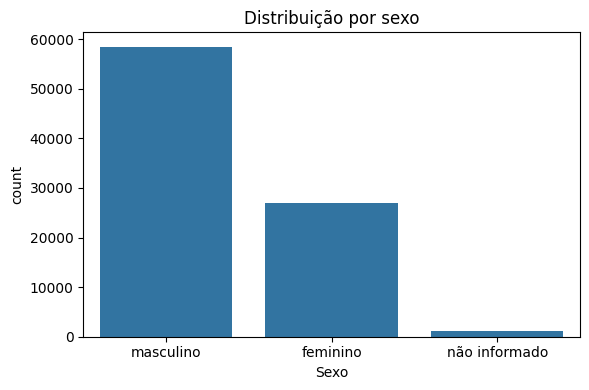

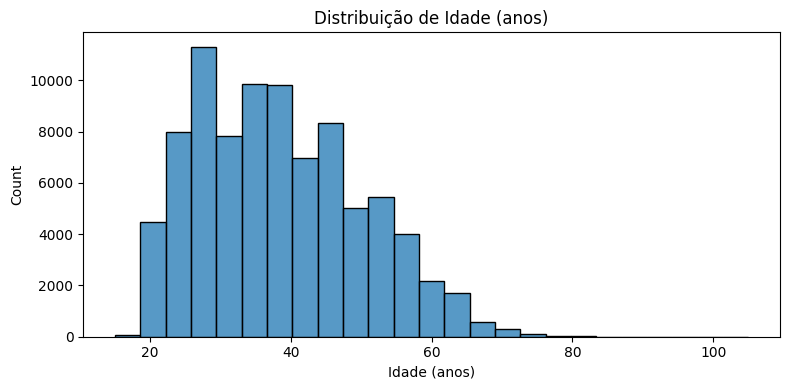

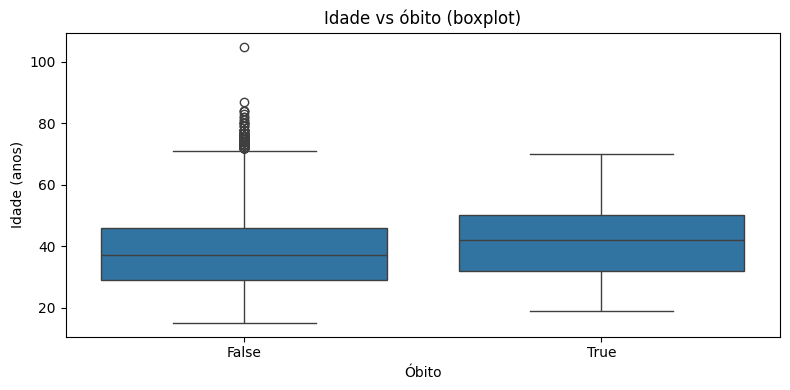

In [12]:

ensure_dir("figs/demografia")
if col_sexo:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col_sexo, order=df[col_sexo].value_counts().index)
    plt.title("Distribuição por sexo")
    plt.xlabel("Sexo")
    plt.tight_layout()
    plt.savefig("figs/demografia/sexo_dist.png", bbox_inches="tight")
    plt.show()
    plt.close()

if "idade_anos" in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df["idade_anos"].dropna(), kde=False, bins=25)
    plt.title("Distribuição de Idade (anos)")
    plt.xlabel("Idade (anos)")
    plt.tight_layout()
    plt.savefig("figs/demografia/idade_hist.png", bbox_inches="tight")
    plt.show()
    plt.close()

# Boxplot idade por óbito_flag
if "idade_anos" in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="obito_flag", y="idade_anos", data=df)
    plt.title("Idade vs óbito (boxplot)")
    plt.xlabel("Óbito")
    plt.ylabel("Idade (anos)")
    plt.tight_layout()
    plt.savefig("figs/demografia/idade_vs_obito_box.png", bbox_inches="tight")
    plt.show()
    plt.close()

In [13]:

# Municípios com maior proporção de óbitos (apenas top N por ocorrências)
def top_ratio_by_group(df, group_col, event_col="obito_flag", top_n=20, min_events=50):
    group = df.groupby(group_col).agg(total=("obito_flag", "size"), n_obitos=(event_col, "sum"))
    group = group[group["total"] >= min_events]
    group["taxa_obito"] = group["n_obitos"] / group["total"]
    group = group.sort_values("taxa_obito", ascending=False).head(top_n)
    return group

if col_municipio:
    top_mun_obito = top_ratio_by_group(df, col_municipio, min_events=20, top_n=10)
    print("\nTop municípios por taxa de óbito (>=20 eventos):")
    print(top_mun_obito.head(10))
    top_mun_obito.to_csv("figs/top_municipios_taxa_obito.csv")

# CBOs com maior taxa de óbito
if col_cbo:
    top_cbo_obito = top_ratio_by_group(df, col_cbo, min_events=20, top_n=15)
    print("\nTop CBO por taxa de óbito (>=20 eventos):")
    print(top_cbo_obito.head(15))
    top_cbo_obito.to_csv("figs/top_cbo_taxa_obito.csv")


Top municípios por taxa de óbito (>=20 eventos):
                            total  n_obitos  taxa_obito
municipio_empregador                                   
150150-benevides               23         2    0.086957
170950-gurupi                  24         2    0.083333
411330-laranjeiras do sul      25         2    0.080000
412630-sengés                  30         2    0.066667
411670-nova aurora-pr          21         1    0.047619
150360-itaituba                22         1    0.045455
330520-são pedro da aldeia     22         1    0.045455
150060-altamira                23         1    0.043478
352730-louveira                47         2    0.042553
350780-brodósqui               24         1    0.041667

Top CBO por taxa de óbito (>=20 eventos):
                                               total  n_obitos  taxa_obito
cbo                                                                       
951310-mantenedor de sist. eletroeletrônicos      20         1    0.050000
991310-mon

In [14]:
df.drop('unnamed_0', axis=1)

,agente_causador_acidente,data_acidente,cbo,cid10,cnae_empregador,indica_óbito_acidente,municipio_empregador,sexo,uf_munic_acidente,data_nascimento,cbo_detalhado,data_afastamento,data_acidente_parsed,data_nascimento_parsed,idade_anos,obito_flag,ano
0,rua e estrada - superficie utilizada para sus,2023-01-01,324115-tec. em radiologia e imagenologia,s52.6 frat da extremidade distal do radio e c,atividades de associacoes de defesa de direit,não,354780-santo andré-sp,masculino,maranhão,1980-02-18,NaN,NaN,2023-01-01,1980-02-18,45.0,False,2023
1,"superficie e estrutura, nic",2023-01-01,954125-oper. eletromecânico,s83.3 ruptura atual cartilagem articulacao jo,fundicao de metais nao-ferrosos e suas ligas,não,354060-porto feliz,masculino,maranhão,1993-01-29,NaN,NaN,2023-01-01,1993-01-29,32.0,False,2023
2,rua e estrada - superficie utilizada para sus,2023-01-01,717020-servente de obras,v28.5 passageiro acid trans,servicos de engenharia,não,260960-olinda,masculino,pará,1989-06-11,NaN,NaN,2023-01-01,1989-06-11,36.0,False,2023
3,"veiculo, nic",2023-01-01,421125-oper. caixa,s42.2 frat da extremidade super do umero,"comercio varejista de mercadorias em geral, c",não,160030-macapá,masculino,paraíba,1993-05-02,NaN,NaN,2023-01-01,1993-05-02,32.0,False,2023
4,animal vivo,2023-01-01,334110-inspetor de alunos de escola pública,v28.4 condutor acid trans,ensino fundamental,não,355710-votuporanga,masculino,maranhão,2003-05-07,NaN,NaN,2023-01-01,2003-05-07,22.0,False,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86566,impacto de pes. contra objeto em movimento,2023-04-01,784205-alimentador de linha de prod.,s02.7 frat mult envolv ossos do cranio e face,fundicao de metais nao-ferrosos e suas ligas,não,317070-varginha,masculino,rondônia,2003-10-27,NaN,NaN,2023-04-01,2003-10-27,21.0,False,2023
86567,"escada movel ou fixada, nic",2023-04-01,322205-tec. de enfermagem,m62.6 distensao muscular,atividades de atendimento hospitalar,não,410690-curitiba,masculino,roraima,1980-04-26,NaN,NaN,2023-04-01,1980-04-26,45.0,False,2023
86568,absorcao de substancia caustica,2023-05-01,811130-trab. de fabricação de tintas,h16.1 outr ceratites superf s/conjuntivite,"fabricacao de tintas, vernizes, esmaltes e la",não,352930-matão,masculino,maranhão,1976-11-24,NaN,NaN,2023-05-01,1976-11-24,48.0,False,2023
86569,rua e estrada - superficie utilizada para sus,2023-04-01,223505-enfermeiro,s02.2 frat dos ossos nasais,atividades de atencao ambulatorial executadas,não,355030-são paulo,feminino,maranhão,1987-02-22,NaN,NaN,2023-04-01,1987-02-22,38.0,False,2023


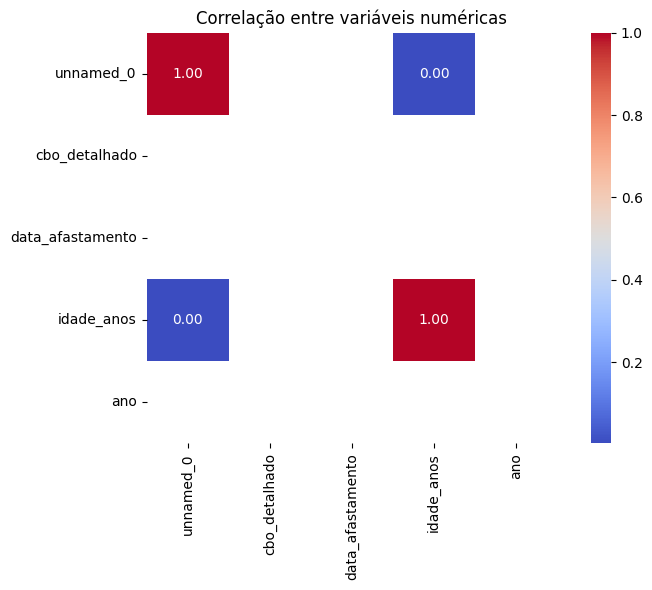

In [15]:

# Seleciona colunas numéricas e calcula correlação pearson
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlação entre variáveis numéricas")
    plt.tight_layout()
    plt.savefig("figs/correlacao_numerica.png", bbox_inches="tight")
    plt.show()
    plt.close()
    corr.to_csv("figs/correlacao_numerica.csv")

In [21]:
)
def series_to_col(s):
    vals = list(s.index.astype(str))
    counts = list(s.values.astype(int))
    # pad to 10
    while len(vals) < 10:
        vals.append(np.nan)
        counts.append(np.nan)
    return vals[:10], counts[:10]

sa, na = series_to_col(top_agentes)
sm, nm = series_to_col(top_municipios)
saf, naf = series_to_col(top_agentes_fatais)
sc, nc = series_to_col(top_cbos)
sci, nci = series_to_col(top_cnaes)

resumo = pd.DataFrame({
    "rank": list(range(1,11)),
    "top_agente": sa, "qtd_agente": na,
    "top_municipio": sm, "qtd_municipio": nm,
    "top_agente_fatal": saf, "qtd_agente_fatal": naf,
    "top_cbo": sc, "qtd_cbo": nc,
    "top_cnae": sci, "qtd_cnae": nci
})

resumo.to_excel("resumo_top10_lado_a_lado.xlsx", index=False)
print("\nResumo top10 salvo em resumo_top10_lado_a_lado.xlsx")

# também salvar cada topN como csv para inspeção
top_agentes.to_csv("figs/top10/top10_agentes.csv", header=["count"])
top_municipios.to_csv("figs/top10/top10_municipios.csv", header=["count"])
top_agentes_fatais.to_csv("figs/top10/top10_agentes_fatais.csv", header=["count"])
top_cbos.to_csv("figs/top10/top10_cbos.csv", header=["count"])
top_cnaes.to_csv("figs/top10/top10_cnaes.csv", header=["count"])



Resumo top10 salvo em resumo_top10_lado_a_lado.xlsx


In [22]:

# Estatísticas básicas por coluna
col_summary = []
for c in df.columns:
    col_summary.append({
        "coluna": c,
        "dtype": str(df[c].dtype),
        "n_unique": df[c].nunique(dropna=True),
        "n_missing": df[c].isna().sum(),
        "pct_missing": df[c].isna().mean()
    })
col_summary_df = pd.DataFrame(col_summary).sort_values("pct_missing", ascending=False)
col_summary_df.to_excel("col_summary.xlsx", index=False)
print("Sumário das colunas salvo em col_summary.xlsx")

print("\n--- FIM da EDA ---")
print("Figuras salvas em subpastas de 'figs/'.")
print("Arquivos Excel/CSV gerados: resumo_top10_lado_a_lado.xlsx, col_summary.xlsx, e arquivos em figs/top10/")



Sumário das colunas salvo em col_summary.xlsx

--- FIM da EDA ---
Figuras salvas em subpastas de 'figs/'.
Arquivos Excel/CSV gerados: resumo_top10_lado_a_lado.xlsx, col_summary.xlsx, e arquivos em figs/top10/


/tmp/ipython-input-573173788.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CATS_23_24.csv")


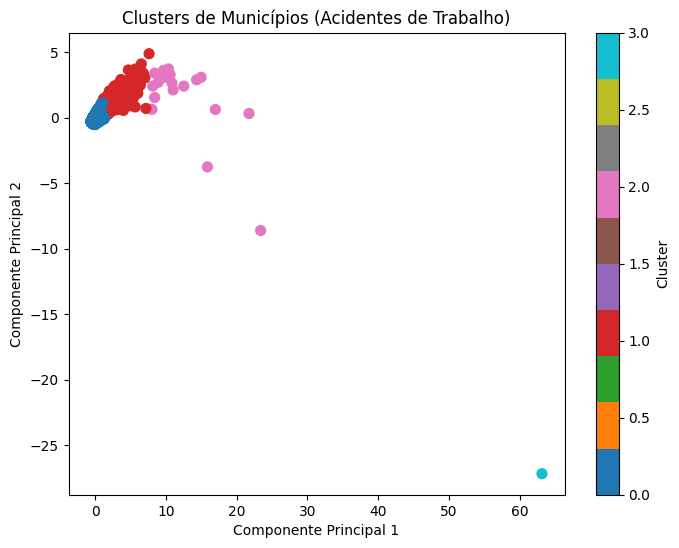

         Total_Acidentes      Qtd_CBO    Qtd_CNAE  Acidentes_Fatais
Cluster                                                            
0              47.489377    21.069051   11.132082          0.284348
1            1214.033654   286.057692  136.735577          4.028846
2            8111.894737   852.578947  331.052632         27.842105
3           79790.000000  2440.000000  717.000000        192.000000


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# =========================
# 1. Carregar e preparar os dados
# =========================
df = pd.read_csv("CATS_23_24.csv")
df.columns = [col.strip().replace(" ", "_").replace(".", "").replace("/", "_") for col in df.columns]

# Criar base agregada por município
df_cluster = df.groupby("Municipio_Empregador").agg({
    "Agente__Causador__Acidente": "count",
    "CBO": "nunique",
    "CNAE_Empregador": "nunique",
    "Indica_Óbito_Acidente": lambda x: (x.str.lower()=="sim").sum()
}).reset_index()

df_cluster.rename(columns={
    "Agente__Causador__Acidente": "Total_Acidentes",
    "CBO": "Qtd_CBO",
    "CNAE_Empregador": "Qtd_CNAE",
    "Indica_Óbito_Acidente": "Acidentes_Fatais"
}, inplace=True)

# =========================
# 2. Normalização
# =========================
features = ["Total_Acidentes", "Qtd_CBO", "Qtd_CNAE", "Acidentes_Fatais"]
X = df_cluster[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# 3. K-Means Clustering
# =========================
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

# =========================
# 4. Redução de Dimensão (PCA para visualização)
# =========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_cluster["Cluster"], cmap="tab10", s=50)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Clusters de Municípios (Acidentes de Trabalho)")
plt.colorbar(label="Cluster")
plt.show()

# =========================
# 5. Ver resumo dos clusters
# =========================
cluster_summary = df_cluster.groupby("Cluster")[features].mean()
print(cluster_summary)

# Salvar resultados
df_cluster.to_excel("clusters_municipios.xlsx", index=False)